## This Kernel tries to predict a pulsar star using SVM

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pulsar-star/pulsar_stars.csv


In [4]:
data = '/kaggle/input/pulsar-star/pulsar_stars.csv'
df = pd.read_csv(data)

In [5]:
df.head()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


In [16]:
df['target_class'].value_counts()

0    16259
1     1639
Name: target_class, dtype: int64

#### Our objective is to predict the `target_class` which has two distinct values.
We will try to achieve this using Support Vector Machines<br>
> **Q:** Can this be achieved using Logistic Regression as well. What is the difference between Logistic Regression and SVM?

First we will check our features and perform normalization
<ol>
    <li> How many features are there ? Are they numeric or we need to convert from descriptive to numeric.</li>
    <li> We will check for outliers in the features. We can configure our hyper-parameter C for adjusting to outliers </li>
</ol>

> There are two types of SVM. Hard Margin and Soft Margin. Soft Margin uses hyperparameter "C" for adjusting to outliers whereas Hard Margin does not deal with outliers.

In [19]:
df.info() #check for datatypes and counts.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   IP Mean          17898 non-null  float64
 1   IP Sd            17898 non-null  float64
 2   IP Kurtosis      17898 non-null  float64
 3   IP Skewness      17898 non-null  float64
 4   DM-SNR Mean      17898 non-null  float64
 5   DM-SNR Sd        17898 non-null  float64
 6   DM-SNR Kurtosis  17898 non-null  float64
 7   DM-SNR Skewness  17898 non-null  float64
 8   target_class     17898 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 1.2 MB


In [21]:
#do we need to normalize the features? 
#to answer this question we can check the output of describe()
round(df.describe(),2)

,IP Mean,IP Sd,IP Kurtosis,IP Skewness,DM-SNR Mean,DM-SNR Sd,DM-SNR Kurtosis,DM-SNR Skewness,target_class
count,17898.00,17898.00,17898.00,17898.00,17898.00,17898.00,17898.00,17898.00,17898.00
mean,111.08,46.55,0.48,1.77,12.61,26.33,8.30,104.86,0.09
std,25.65,6.84,1.06,6.17,29.47,19.47,4.51,106.51,0.29
min,5.81,24.77,-1.88,-1.79,0.21,7.37,-3.14,-1.98,0.00
25%,100.93,42.38,0.03,-0.19,1.92,14.44,5.78,34.96,0.00
50%,115.08,46.95,0.22,0.20,2.80,18.46,8.43,83.06,0.00
75%,127.09,51.02,0.47,0.93,5.46,28.43,10.70,139.31,0.00
max,192.62,98.78,8.07,68.10,223.39,110.64,34.54,1191.00,1.00


From the above output we can see that different features have different domains. We can restrict them to have values between 0 to 1 by normalizing the features. Normalizing features speeds up learning. <br>
We normalize features by substracing mean and then dividing by standard deviation. <br>
We can simply use `sklearn.preprocessing.StandardScaler` perform these operations on all the features simultaneously.<br><br>
<em>But firstly we will separate out the `target_class` column, as we need not scale this column</em>


In [40]:
#features
X = df.drop(['target_class'],axis=1) # 0 is rows and 1 is column, we are dropping the entire column
#target variable
y = df['target_class']
X.head()

,IP Mean,IP Sd,IP Kurtosis,IP Skewness,DM-SNR Mean,DM-SNR Sd,DM-SNR Kurtosis,DM-SNR Skewness
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306


In [41]:
#now we will normalize the features

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() #initialize a standard scaler
X = scaler.fit_transform(X) #use it to normalize the data

X[1:2,:] # compare this output against the above non-normalized data

#also note that now X is a numpy array whereas previously it was a dataframe.

array([[-0.3341682 ,  1.80226533, -0.01178476, -0.37053549, -0.37110188,
        -0.5889241 ,  0.50442694,  0.21158145]])


<h3>Do we have outliers in the dataset, do we need to configure hyperparameter C</h3>

<h4>To understand this better we will go through below concepts and finally use boxplots to answer this question</h4>

**what are 25%, 50%, 75% in this output?**
<br>
Firstly 50% is the median of the numerical series, which is the middle value of a series of numbers.<br>
25th Percentile(also called Q1 or First Quartile) is the middle value between smallest number and midean of a series.<br>
50th Percentile(Q2) is the median of a series.<br>
75th Percentile((also called Q3 or Third Quartile)) is the median between 50% and largest number in the series.<br>
e.g. for IP Mean column median is 115.08; minmum is 5.8 and 25%=100.93 is the middle value between 5.8 and 115.
<br>

**boxplots can show us the outliers in a plot automatically. But to showcase this boxplots uses above three measures with IQR (range between 25% to 75%). And two separate definition for "minimum" and "maximum".**
<br>minimum = 25% - 1.5\*IQR
<br>maximum = 75% + 1.5\*IQR

<em> anything beyond minimum and maximum are considered as outliers </em>

> mathematically can you understand the intuition behind this?

Refer this [article](https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51)
It relates to how a normal distribution is spread out. The last 0.7 percent data is considered as outliers.

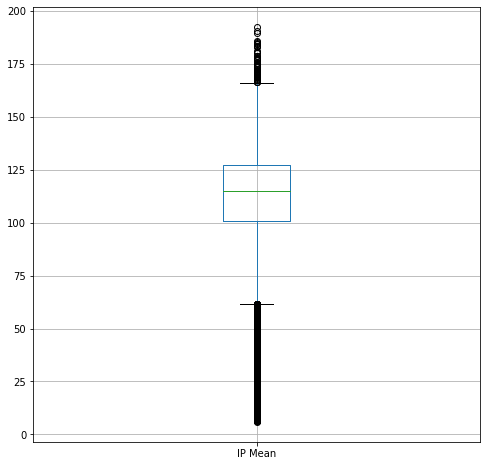

In [49]:
df.boxplot(column='IP Mean',figsize=(8,8))
#in the below plot box's boundaries are Q1 and Q3, The middle line in the box is Q2.
#The Black horizontal lines outside the box are minimum and maximum as defined earlier.
#the continous overlapping black circles are outliers.

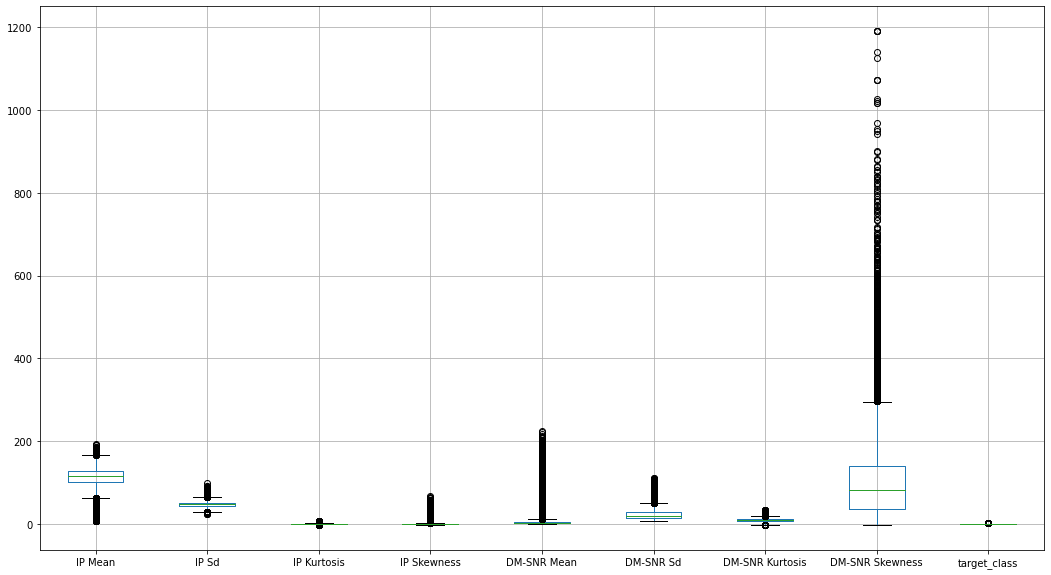

In [68]:
plt.figure(figsize=(18,10))
df.boxplot()
#we can use separate subplots for better view

So, most of the features have outliers. We will still first use SVM without C hyperparameter and see the output.
To run SVM we will first split the data into train and test set.


In [72]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)
#note first X are assigned then y are assigned in the assignment statement
X_train.shape , X_test.shape

((14318, 8), (3580, 8))

In [73]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train,y_train)
y_pred = svc.predict(X_test)
from sklearn.metrics import accuracy_score
print('Model accuracy without C:',accuracy_score(y_test,y_pred))

Model accuracy without C: 0.9826815642458101


In [74]:
svc = SVC(C=100)
svc.fit(X_train,y_train)
y_pred = svc.predict(X_test)
print('Model accuracy with C=100:',accuracy_score(y_test,y_pred))

Model accuracy with C=100: 0.9832402234636871


In [75]:
svc = SVC(C=1000)
svc.fit(X_train,y_train)
y_pred = svc.predict(X_test)
print('Model accuracy with C=100:',accuracy_score(y_test,y_pred))

Model accuracy with C=100: 0.9815642458100559


The model is working slightly better with C=100, soft margin classifier.